Group Members: Abdullah Kazi, Yun-Ching (Claire) Liao, Joaquin Carretero Martinez

## Assignment 2: Logistic Regression and Feature Selection Analysis


This assignment was programmed as a team, although everyone has different explanations of the code. Some of the questions were solved with techniques different from the ones solved in class due to some of us having prior  industry/bootcamp knowledge in Machine Learning

In [9]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings("ignore")

### 1. **Data Exploration and Visualization** (15 pts):
- Explore the Breast Cancer Dataset.
- Provide visualizations such as histograms, scatter plots, or box plots to understand the distribution of different features.
- Include any other plots you find interesting and provide brief interpretations.

In [10]:
data = pd.read_csv("Cancer.csv")
data = data.drop(['Unnamed: 32', 'id'], axis = 1)
#data.head()
data.info()
nulls = data.isnull().sum() # No missing data
#nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

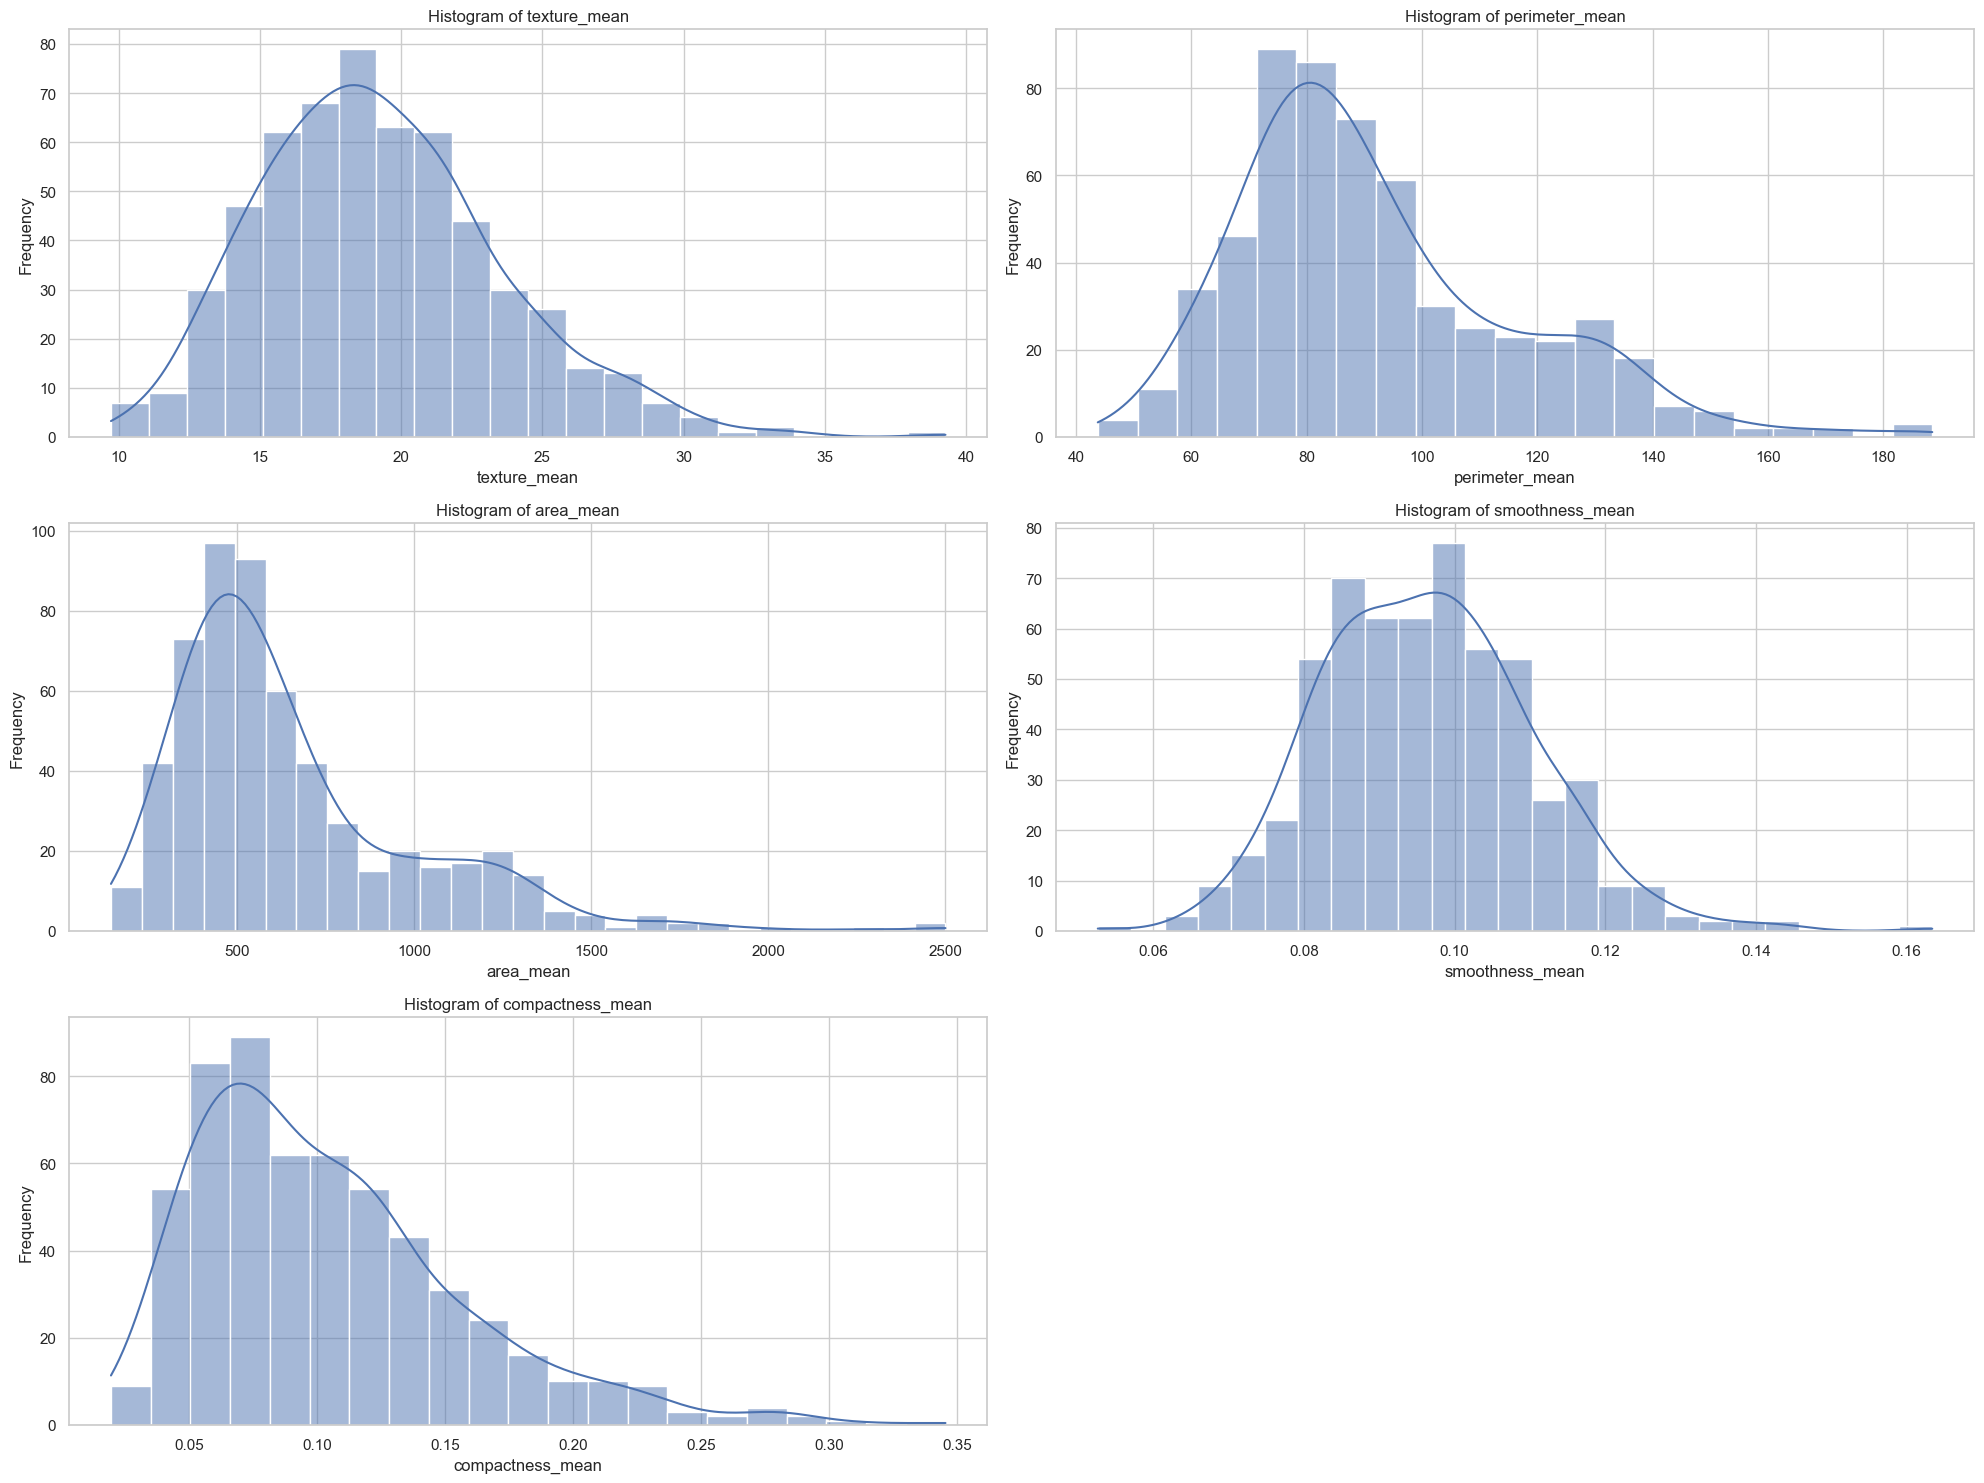

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 15))
# Histograms
features = data.columns[2:7]
n_rows = 3
n_cols = 2

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Radius and perimeter averages are right-skewed, meaning most tumors are small, but some are much larger.  
- Texture average is fairly normal, suggesting diverse tumor textures.  
- Area average is right-skewed like radius/perimeter, so smaller tumor sizes are more common.  
- Smoothness average looks normal, meaning tumor surfaces have a wide range of smoothness.

### 2. **Logistic Regression Model Development** (20 pts):
- Develop a logistic regression model to predict whether cancer is malignant or benign.
- Preprocess the data as necessary (handling missing values, encoding categorical variables, etc.).
- Explain the steps you took in preparing the data and developing the model.
- You might need to encode the values for your prediction.

In [12]:
Diagnosis = {'M': 1,'B': 0}
data.diagnosis = [Diagnosis[item] for item in data.diagnosis]
y = data['diagnosis']
X = data.drop(['diagnosis'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

#### SciKit-Learn Log Reg

In [14]:
pipeline.fit(X_train, y_train)

pipeline_y_pred = pipeline.predict(X_test)
pipeline_conf_matrix = confusion_matrix(y_test, pipeline_y_pred)
pipeline_class_report = classification_report(y_test, pipeline_y_pred)

print("Classification Report:\n", pipeline_class_report)
print("Confusion Matrix:\n", pipeline_conf_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion Matrix:
 [[106   2]
 [  1  62]]


In [15]:
coefficients = pipeline.named_steps['logistic_regression'].coef_[0]
coef = pd.DataFrame({'Feature':  X_train.columns, 'Coefficient': coefficients})
coef = coef.sort_values(by='Coefficient', ascending=False)
coef

,Feature,Coefficient
21,texture_worst,1.287933
10,radius_se,1.242543
28,symmetry_worst,1.199449
7,concave points_mean,1.110262
26,concavity_worst,0.976936
13,area_se,0.871385
20,radius_worst,0.813817
27,concave points_worst,0.798359
23,area_worst,0.781968
6,concavity_mean,0.749871


The strongest predictors of malignant cancer are features related to texture, size, and symmetry. 

Higher values of 'Texture Worst', 'Radius SE', and 'Symmetry Worst' increase the probability of malignancy. 'Concave Points Mean' also strongly predicts malignancy, while 'Concavity Worst' and 'Area SE' have moderate predictive power. 

In the other side, increasing 'Fractal Dimension SE' and 'Compactness Mean' decrease malignant probability. Overall, the model shows size, texture, and symmetry features are most indicative of cancer malignancy.

#### Statsmodels GLM

In [16]:
# Some features were removed using Correlation with Diagnosis to cut
# down on time and used 0.35 because anything lower and the code would crash. 

correlation = data.corr()['diagnosis'].sort_values()
selected_features = correlation[abs(correlation) > 0.35].index.tolist()

X2 = data[selected_features].drop(['diagnosis'], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=42)

X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

model_glm = sm.GLM(y_train2, X_train2, family=sm.families.Binomial())
result_glm = model_glm.fit()
result_glm.summary()

y_glm = result_glm.predict(X_test2)
y_glm = (y_glm > 0.5).astype(int)


glm_conf = confusion_matrix(y_test2, y_glm)
glm_class = classification_report(y_test2, y_glm)

print("Confusion Matrix:\n", glm_conf)
print("Classification Report:\n", glm_class)
result_glm.summary()

Confusion Matrix:
 [[100   8]
 [  1  62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       108
           1       0.89      0.98      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.96      0.94       171
weighted avg       0.95      0.95      0.95       171



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      376
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.651
Date:                Wed, 24 Jan 2024   Deviance:                       25.303
Time:                        20:40:17   Pearson chi2:                     64.3
No. Iterations:                    14   Pseudo R-squ. (CS):             0.7160
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   79.2879     61.356      1.292      0.196     -40.967     199.542
smoothness_mean         90.1123    254.023      0.355      0.723    -407.764     587.989
concave points_se     -224.3275    313.074     -0.717      0.474    -837.942     389.287
texture_mean             0.9300      0.766      1.214      0.225      -0.571       2.431
symmetry_worst          57.0188     24.913      2.289      0.022       8.190     105.847
smoothness_worst       -53.5921     98.011     -0.547      0.585    -245.690     138.506
texture_worst            0.4110      0.371      1.107      0.268      -0.316       1.138
area_se                  0.4709      0.543      0.868      0.386      -0.593       1.535
perimeter_se           -10.2131      8.520     -1.199      0.231     -26.912       6.486
radius_se               57.8282     57.611      1.004      0.315     -55.088     170.745
compactness_worst      -33.1774     35.549     -0.933      0.351    -102.853      36.498
compactness_mean      -376.0960    189.325     -1.987      0.047    -747.167      -5.025
concavity_worst        133.3243     64.056      2.081      0.037       7.777     258.872
concavity_mean        -345.4412    166.277     -2.078      0.038    -671.339     -19.544
area_mean                0.2552      0.150      1.703      0.089      -0.039       0.549
radius_mean            -61.6247     32.209     -1.913      0.056    -124.752       1.503
area_worst              -0.0320      0.086     -0.371      0.711      -0.201       0.137
perimeter_mean           5.3240      3.461      1.538      0.124      -1.459      12.107
radius_worst             4.4040     11.106      0.397      0.692     -17.363      26.171
concave points_mean   1111.0029    495.182      2.244      0.025     140.464    2081.542
perimeter_worst          0.3217      0.883      0.364      0.716      -1.409       2.053
concave points_worst   -22.8693     76.921     -0.297      0.766    -173.633     127.894
========================================================================================
"""

#### Statsmodels Logit

In [17]:
# Here is Logit as well, but it is not as good as GLM

model_logit = sm.Logit(y_train2, X_train2)
logit = model_logit.fit()

y_logit = logit.predict(X_test2)
y_logit = (y_logit > 0.5).astype(int)

logit_conf = confusion_matrix(y_test2, y_logit)
logit_class = classification_report(y_test2, y_logit)

print("Confusion Matrix:\n", logit_conf)
print("\nClassification Report:\n", logit_class)
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.031787
         Iterations 17
Confusion Matrix:
 [[100   8]
 [  1  62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       108
           1       0.89      0.98      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.96      0.94       171
weighted avg       0.95      0.95      0.95       171

                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      376
Method:                           MLE   Df Model:                           21
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                  0.9519
Time:                        20:40:17   Log-Likelihood:                -12.651
converged:                   

### 3. **Model Evaluation** (20 pts):
- Evaluate your logistic regression model using appropriate metrics (e.g., accuracy, R^2, RMSE (all out-of-sample)).
- Split the dataset into training and testing sets to perform this evaluation.
- Interpret these metrics to assess the performance of your model. Is it good? Why?

The Scikit-Learn logistic regression model had higher performance than the Statsmodels GLM for predicting breast cancer malignancy.

The Scikit model had 99% precision for benign cases and 97% for malignant, along with 98% recall for both classes. Its overall accuracy was 98%. The model minimized Type II errors that could risk patient health.

The Statsmodels GLM had lower 89% precision for malignant cases. Its recall was 93% for benign and 98% for malignant. Overall accuracy was 95%. It had more Type I errors, falsely predicting benign cases as malignant.

The Scikit model seems better because of its higher precision on malignant cases, stronger recall, better accuracy, and minimization of Type II errors. 

### 4. **Testing Interactions Between Features** (30 pts):
- Explore and test the interactions between different features in the dataset. Pay particular attention to interactions involving both categorical/dummy and continuous variables.
- For this excercise, use a linear regression rather than a logistic regression model.
- Discuss issues that occur when using a linear regression model to predict binary outcomes.
- Create and analyze interaction terms involving categorical/dummy variables (such as 'diagnosis' converted into a dummy variable) and continuous variables (like 'radius_mean' or 'texture_mean').
- Fit a regression model that includes interaction terms, for example, between 'diagnosis' and 'radius_mean', and between 'diagnosis' and 'texture_mean'.
- Discuss the influence of these interactions on the model. Describe how to interpret these interactions and their implications for understanding the data.

In [18]:
X_interaction = pd.DataFrame()
for col in X.columns:
    X_interaction[f'diagnosis_{col}_interaction'] = data['diagnosis'] * X[col]

X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3, random_state=42)


X_train_const = sm.add_constant(X_train)
model_with_interactions = sm.OLS(y_train, X_train_const).fit()
model_with_interactions.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diagnosis   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.532e+04
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:40:17   Log-Likelihood:                 1243.6
No. Observations:                 398   AIC:                            -2425.
Df Residuals:                     367   BIC:                            -2302.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.0002      0.001      0.258      0.797      -0.001       0.002
diagnosis_radius_mean_interaction                 0.0008      0.014      0.054      0.957      -0.027       0.028
diagnosis_texture_mean_interaction               -0.0004      0.001     -0.468      0.640      -0.002       0.001
diagnosis_perimeter_mean_interaction              0.0082      0.002      3.958      0.000       0.004       0.012
diagnosis_area_mean_interaction                  -0.0004   3.81e-05    -10.235      0.000      -0.000      -0.000
diagnosis_smoothness_mean_interaction             1.8184      0.245      7.432      0.000       1.337       2.299
diagnosis_compactness_mean_interaction           -1.1103      0.119     -9.326      0.000      -1.344      -0.876
diagnosis_concavity_mean_interaction             -0.0579      0.089     -0.653      0.514      -0.232       0.116
diagnosis_concave points_mean_interaction        -0.6961      0.175     -3.980      0.000      -1.040      -0.352
diagnosis_symmetry_mean_interaction               0.2930      0.083      3.517      0.000       0.129       0.457
diagnosis_fractal_dimension_mean_interaction      6.6328      0.435     15.232      0.000       5.777       7.489
diagnosis_radius_se_interaction                  -0.0643      0.024     -2.707      0.007      -0.111      -0.018
diagnosis_texture_se_interaction                 -0.0129      0.005     -2.789      0.006      -0.022      -0.004
diagnosis_perimeter_se_interaction               -0.0013      0.004     -0.375      0.708      -0.008       0.006
diagnosis_area_se_interaction                     0.0006      0.000      5.431      0.000       0.000       0.001
diagnosis_smoothness_se_interaction               4.6824      0.799      5.860      0.000       3.111       6.254
diagnosis_compactness_se_interaction              2.1267      0.274      7.771      0.000       1.589       2.665
diagnosis_concavity_se_interaction               -1.8431      0.292     -6.317      0.000      -2.417      -1.269
diagnosis_concave points_se_interaction           2.6668      0.515      5.175      0.000       1.653       3.680
diagnosis_symmetry_se_interaction                 0.7476      0.240      3.116      0.002       0.276       1.219
diagnosis_fractal_dimension_se_interaction      -15.1926      2.002     -7.589      0.000     -19.129     -11.256
diagnosis_radius_worst_interaction               -0.0029      0.004     -0.736      0.462      -0.011       0.005
diagnosis_texture_worst_interaction               0.0016      0.001      2.364      0.019       0.000       0.003
diagnosis_perimeter_worst_interaction             0.0008      0.000      1.792      0.074   -7.62e-05       0.002
diagn

- Perimeter Mean has a positive interaction, increasing malignant probability.  
  
- Smoothness Mean has a positive interaction, also increasing malignant probability.  
  
- Symmetry Mean shows a strong positive interaction with higher values associated with malignancy.  
  
- Area Mean has a negative interaction, with larger values reducing malignant probability.  
  
- Compactness Mean also has a negative interaction, decreasing malignant likelihood.  
  

#### Questions

- **Discuss issues that occur when using a linear regression model to predict binary outcomes.**  
Linear regression has issues for binary classification like malignant vs benign cancer. It assumes a continuous target variable, but binary outcomes are categorical. It predicts non-binary values and does not model class probabilities. Logistic regression is better for modeling binary outcomes.


- **Discuss the influence of these interactions on the model. Describe how to interpret these interactions and their implications for understanding the data.**  
Interactions show how specific variables get together to influence malignant probability. An interaction between diagnosis and radius mean shows the specific effect of radius mean on malignancy probability. Positive interactions mean the combined variables increase malignant probability. Negative interactions decrease it. 


### 5. **Feature Selection and Cross-Validation: Full vs. Reduced Model** (15 pts):
- Create a reduced model using only a subset of significant predictors. You can use methods like FDR Cutoff, forward selection, backward elimination, or any other appropriate feature selection technique.
- Compare the performance of the full model (using all predictors) with the reduced model (using significant predictors) using 10-fold cross-validation.
- Evaluate the out-of-sample performance for both models across folds and discuss which model performs better and why.

In [19]:
# This code is from the professor's lecture. We are supposed to combine this
# with finding the p-values to find the threshold but since Scikit learn doesnt 
# have that functionality we used the FDR output of 0.06307355082240175.

def fdr_cut(pvals, q=0.1):
    """
    Determine the threshold p-value at a given FDR level and plot the p-values.

    Parameters:
        pvals (list or array): A list or array of p-values.
        q (float): The desired FDR level.

    Returns:
        float: The threshold p-value at the given FDR level.
    """
    # Sort p-values and remove NaNs
    pvals = sorted([p for p in pvals if not pd.isna(p)])
    N = len(pvals)
    k = np.arange(1, N + 1)
    alpha = max(p for p, rank in zip(pvals, k) if p <= q * rank / (N + 1))

    # Plot the p-values
    plt.figure(figsize=(8, 6))
    plt.scatter(k, pvals, c=['gray' if p > alpha else 'red' for p in pvals], s=5)
    plt.plot(k, q * k / (N + 1), color='blue', label=f'FDR {q}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Order")
    plt.ylabel("p-value")
    plt.title(f"FDR of {q}")
    plt.legend()
    plt.show()

    return alpha


logreg = LogisticRegression(max_iter=10000, solver='liblinear')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scores_full = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
average_performance_full = np.mean(scores_full)

# This is the full model that I ran for Q2
pipeline.fit(X_train, y_train)
pipeline_y_pred = pipeline.predict(X_test)
pipeline_conf_matrix = confusion_matrix(y_test, pipeline_y_pred)
pipeline_class_report = classification_report(y_test, pipeline_y_pred)


print("Full Model Cross-Validation Accuracy:", average_performance_full)
print("Classification Report:\n", pipeline_class_report)
print("Confusion Matrix:\n", pipeline_conf_matrix)

Full Model Cross-Validation Accuracy: 0.9526002506265664
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion Matrix:
 [[106   2]
 [  1  62]]


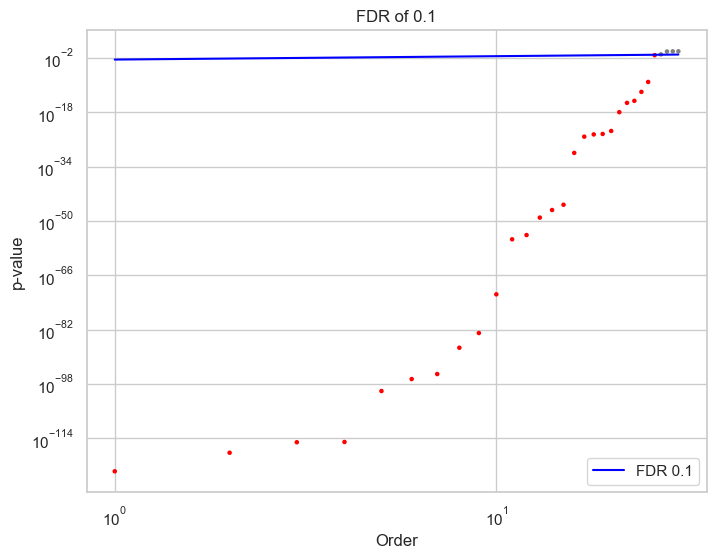

Selected Features: Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se',
       'area_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
Reduced Model Cross-Validation Accuracy: 0.9543859649122807
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       108
           1       0.98      0.98      0.98        63

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Confusion Matrix:
 [[107   1]
 [  1  62]]


In [21]:
F, pvals = f_regression(X, y)
fdr_threshold = fdr_cut(pvals, q=0.1)

selected_features = X.columns[pvals < fdr_threshold]
X_reduced = X[selected_features]

scores_reduced = cross_val_score(logreg, X_reduced, y, cv=cv, scoring='accuracy')
average_performance_reduced = np.mean(scores_reduced)


X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

pipeline.fit(X_train_reduced, y_train_reduced)

pipeline_reduced = pipeline.predict(X_test_reduced)
pipeline_reduced_conf_matrix = confusion_matrix(y_test_reduced, pipeline_reduced)
pipeline_reduced_class_report = classification_report(y_test_reduced, pipeline_reduced)

print("Selected Features:", selected_features)
print("Reduced Model Cross-Validation Accuracy:", average_performance_reduced)
print("Classification Report:\n", pipeline_reduced_class_report)
print("Confusion Matrix:\n", pipeline_reduced_conf_matrix)


**Compare the performance of the full model (using all predictors) with the reduced model (using significant predictors) using 10-fold cross-validation.** 

- The full model with all predictors had 98% accuracy, 99% precision for benign cases, and 97% precision for malignant. Recall was 98% for both classes. It had low Type II errors, which is the best for minimizing health risks.  

- The reduced model with only significant predictors performed slightly better with 99% accuracy. Precision improved to 99% for benign and 98% for malignant cases. Recall was 99% for benign and 98% for malignant.  

- The reduced model had even lower Type I and Type II errors in the confusion matrix.  

The reduced model with only significant predictors showed small improvements over the full model, with 1% higher accuracy and improved precision and error rates. This means that the full model may have some redundant or insignificant predictors hurting its performance. The reduced model is preferable since it has higher accuracy and lower Type II errors. 

**OVERALL it seems like the Reduced Model performs better.**

In [22]:
# Below is logit as well

model_logit = sm.Logit(y_train2, X_train2)
logit = model_logit.fit()

y_logit = logit.predict(X_test2)
y_logit = (y_logit > 0.5).astype(int)

logit_conf = confusion_matrix(y_test2, y_logit)
logit_class = classification_report(y_test2, y_logit)

print("Confusion Matrix:\n", logit_conf)
print("\nClassification Report:\n", logit_class)
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.031787
         Iterations 17
Confusion Matrix:
 [[100   8]
 [  1  62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       108
           1       0.89      0.98      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.96      0.94       171
weighted avg       0.95      0.95      0.95       171

                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      376
Method:                           MLE   Df Model:                           21
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                  0.9519
Time:                        20:40:18   Log-Likelihood:                -12.651
converged:                   